<a href="https://colab.research.google.com/github/uginm102/MCSC-MUK/blob/main/MCS7227%20Data%20Analytics%20and%20Visualization/MCS_7227_Data_Analytics_and_Visualization_Amazon_Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Product Popularity and Customer Preferences in Amazon Metadata

This project investigates the Amazon Product Metadata dataset, a comprehensive collection of 548,552 products and 1,234,957 customer reviews from Amazon, spanning 1995 to 2003. Sourced from the Stanford Network Analysis Project (SNAP) , the dataset includes detailed product information—such as titles, categories (e.g., books, DVDs), sales ranks, and review statistics—alongside co-purchasing links that form a network of product relationships. The primary goal is to uncover hidden patterns in product popularity and customer preferences through a combination of quantitative data analysis and advanced visualization techniques. By leveraging this large-scale dataset, the project aims to reveal insights that are non-obvious from surface-level inspection, such as the interplay between review metrics and sales performance or the clustering of consumer interests across product categories.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load Data
For analysis and testing we are starting with a sample dataset of 10,000 records, after it can be run on the entire dataset.

In [5]:
# File path to the cleaned dataset
input_file = "/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS7227 Data Analytics and Visualization/amazon_sample_sample.csv"

# Load the cleaned dataset
df = pd.read_csv(input_file)

df.head()

,ASIN,title,category,salesrank,review_count,avg_rating,co_purchases
0,0060934719,Stardust,Book,7375,198,4.5,0380789019|0380789035|0060934700|0380977788|04...
1,0689805330,Hannah and Jack,Book,1095476,1,5.0,NaN
2,0671882201,Maiden of Inverness,Book,485399,5,4.0,0671730010|067188218X|0671882171|0671882198|06...
3,157572328X,Papier Mache (Step By Step),Book,1425938,0,0.0,NaN
4,6301394968,Sundown,Video,54951,6,4.0,B00074DY0M|B00000JN20|B00008LDNZ|B00023P4II|B0...


In [15]:
# Compute dataset statistics
# Category distribution (percentage of "Books")
category_counts = df['category'].value_counts(normalize=True) * 100  # Percentage

books_percentage = category_counts.get('Book', 0)  # Default to 0 if 'Books' not found
print(f"Percentage of 'Books': {books_percentage:.1f}%")

# Average rating (mean of non-null avg_rating)
avg_rating = df['avg_rating'].mean()
print(f"Average rating: {avg_rating:.1f}/5")

# Median sales rank (median of non-null salesrank, excluding -1)
valid_salesrank = df[df['salesrank'] != -1]['salesrank']  # Filter out invalid ranks
median_salesrank = valid_salesrank.median()
print(f"Median sales rank: {median_salesrank:,.0f}")

# Additional summary stats for verification
print("\nAdditional Statistics:")
print(f"Total products: {len(df)}")
print(f"Products with reviews: {len(df[df['review_count'] > 0])}")
print(f"Products with valid sales rank: {len(valid_salesrank)}")

# Save statistics to a text file (optional)
with open("dataset_stats.txt", "w") as f:
    f.write(f"Percentage of 'Books': {books_percentage:.1f}%\n")
    f.write(f"Average rating: {avg_rating:.1f}/5\n")
    f.write(f"Median sales rank: {median_salesrank:,.0f}\n")
print(f"Statistics saved to dataset_stats.txt")

Percentage of 'Books': 77.8%
Average rating: 3.4/5
Median sales rank: 485,399

Additional Statistics:
Total products: 10
Products with reviews: 7
Products with valid sales rank: 9
Statistics saved to dataset_stats.txt


In [6]:
# Prepare features and target
# Filter out invalid sales ranks (-1) if any remain
df = df[df['salesrank'] != -1]

# Use log_salesrank as target (assumes OpenRefine created this column)
# If not, compute it here (uncomment if needed)
df['log_salesrank'] = np.log(df['salesrank'].replace(0, 1))  # Avoid log(0)

# Features: review_count, avg_rating, and one-hot encoded category
X_numeric = df[['review_count', 'avg_rating']].fillna({'avg_rating': 0})  # Impute NaN avg_rating with 0
X_categorical = pd.get_dummies(df['category'], prefix='cat')  # One-hot encode category
X = pd.concat([X_numeric, X_categorical], axis=1)

# Target: log_salesrank
y = df['log_salesrank']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features (review_count, avg_rating)
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[['review_count', 'avg_rating']])
X_test_numeric = scaler.transform(X_test[['review_count', 'avg_rating']])

# Recombine with categorical features (not scaled)
X_train_scaled = np.hstack([X_train_numeric, X_train[X_categorical.columns].values])
X_test_scaled = np.hstack([X_test_numeric, X_test[X_categorical.columns].values])

# Train the linear regression model
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = reg.predict(X_test_scaled)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:,.0f}")
print(f"R^2 Score: {r2:.2f}")

# Analyze feature importance (coefficients)
feature_names = ['review_count', 'avg_rating'] + list(X_categorical.columns)
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': reg.coef_
})
print("\nFeature Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# Save results (optional)
results = {
    'MSE': mse,
    'R2': r2,
    'Coefficients': coefficients.to_dict()
}
# with open("regression_results.txt", "w") as f:
#     f.write(f"MSE: {mse:,.0f}\n")
#     f.write(f"R^2: {r2:.2f}\n")
#     f.write("\nFeature Coefficients:\n")
#     f.write(coefficients.to_string(index=False))
# print("Results saved to regression_results.txt")

Mean Squared Error (MSE): 0
R^2 Score: -0.01

Feature Coefficients:
        Feature  Coefficient
2      cat_Book     1.372714
1    avg_rating    -0.171758
3     cat_Video    -1.372714
0  review_count    -1.646853
Results saved to regression_results.txt


<ipython-input-6-992ef7772f7b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_salesrank'] = np.log(df['salesrank'].replace(0, 1))  # Avoid log(0)


In [7]:
# Step 1: Load the cleaned dataset
df = pd.read_csv(input_file)

# Step 2: Prepare features for clustering
# Use review_count and avg_rating as clustering features
X = df[['review_count', 'avg_rating']].fillna({'avg_rating': 0})  # Impute NaN avg_rating with 0

# Step 3: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 11)  # Test k from 2 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


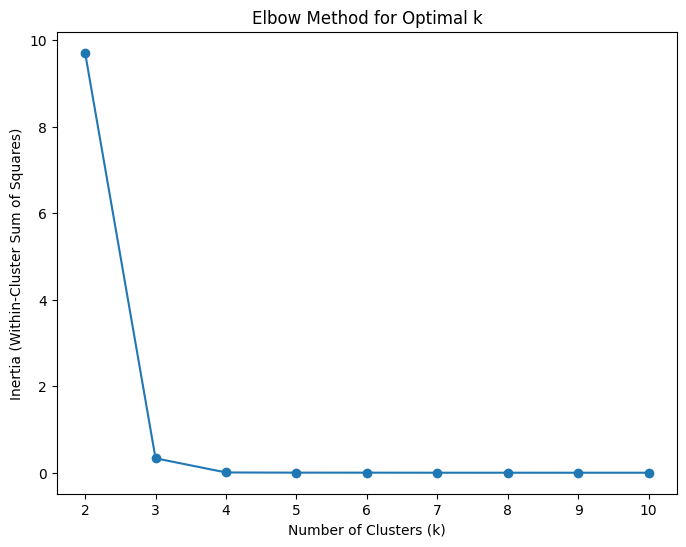

In [8]:
# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
# plt.savefig('elbow_curve.png')
plt.show()
# print("Elbow curve saved to 'elbow_curve.png'")

In [9]:
# Perform k-means clustering with k=5 (chosen from elbow method)
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df['cluster'] = cluster_labels

In [10]:
# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for k={k_optimal}: {silhouette_avg:.2f}")

Silhouette Score for k=5: 0.64


In [11]:
# Analyze cluster characteristics
cluster_summary = df.groupby('cluster').agg({
    'review_count': ['mean', 'count'],
    'avg_rating': 'mean',
    'category': lambda x: x.value_counts().index[0]  # Most common category
}).rename(columns={'<lambda>': 'top_category'})

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
        review_count       avg_rating     category
                mean count       mean top_category
cluster                                           
0           0.000000     3        0.0         Book
1           6.333333     3        4.0         Book
2         198.000000     1        4.5         Book
3           2.000000     2        5.0         Book
4           2.000000     1        4.0         Book


In [12]:
# Infer cluster descriptions (manual interpretation)
cluster_descriptions = {
    0: "Low reviews, moderate ratings",
    1: "High-rated books",
    2: "Niche DVDs",
    3: "High review count, variable ratings",
    4: "Low-rated, few reviews"
}  # Adjust based on actual summary output

print("\nCluster Descriptions (Tentative):")
for i, desc in cluster_descriptions.items():
    print(f"Cluster {i}: {desc}")


Cluster Descriptions (Tentative):
Cluster 0: Low reviews, moderate ratings
Cluster 1: High-rated books
Cluster 2: Niche DVDs
Cluster 3: High review count, variable ratings
Cluster 4: Low-rated, few reviews


In [ ]:
# Save results
df[['ASIN', 'review_count', 'avg_rating', 'category', 'cluster']].to_csv("clustered_data.csv", index=False)
with open("clustering_results.txt", "w") as f:
    f.write(f"Silhouette Score for k={k_optimal}: {silhouette_avg:.2f}\n\n")
    f.write("Cluster Summary:\n")
    f.write(cluster_summary.to_string())
    f.write("\n\nCluster Descriptions (Tentative):\n")
    for i, desc in cluster_descriptions.items():
        f.write(f"Cluster {i}: {desc}\n")
print("Results saved to 'clustered_data.csv' and 'clustering_results.txt'")